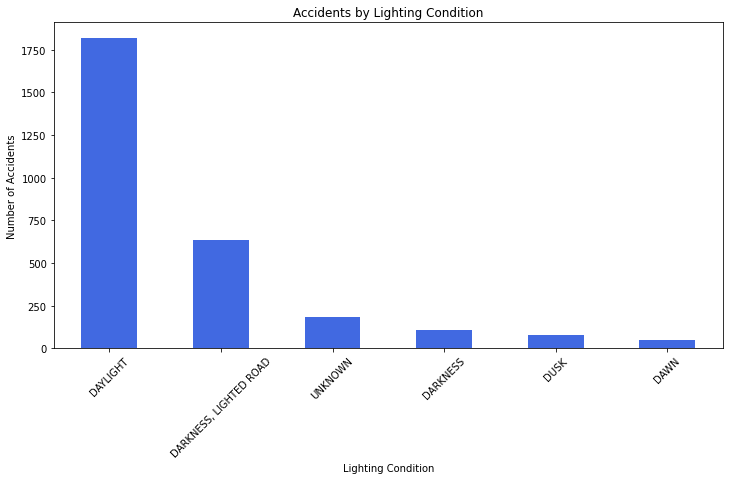

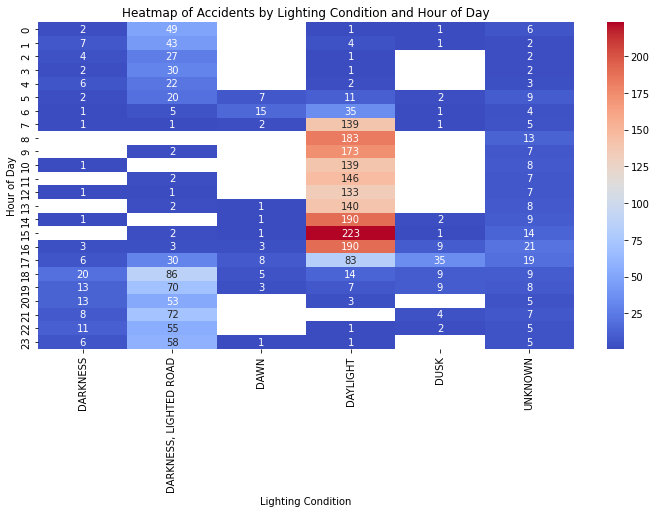

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_cleaned = pd.read_csv("chicago_accidents_cleaned.csv")

# Ensure the date format is correct
df_cleaned["crash_date"] = pd.to_datetime(df_cleaned["crash_date"], errors='coerce')

# ========== Count the number of accidents under different lighting conditions ==========
lighting_counts = df_cleaned["lighting_condition"].value_counts()

plt.figure(figsize=(12, 6))
lighting_counts.plot(kind="bar", color="royalblue")
plt.xlabel("Lighting Condition")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Lighting Condition")
plt.xticks(rotation=45)
plt.show()

# ========== Generate a heatmap for lighting conditions vs. time ==========
df_cleaned["hour"] = df_cleaned["crash_date"].dt.hour  # Extract the hour of the accident occurrence

heatmap_data = df_cleaned.groupby(["hour", "lighting_condition"]).size().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".0f")
plt.xlabel("Lighting Condition")
plt.ylabel("Hour of Day")
plt.title("Heatmap of Accidents by Lighting Condition and Hour of Day")
plt.show()


<Figure size 1008x432 with 0 Axes>

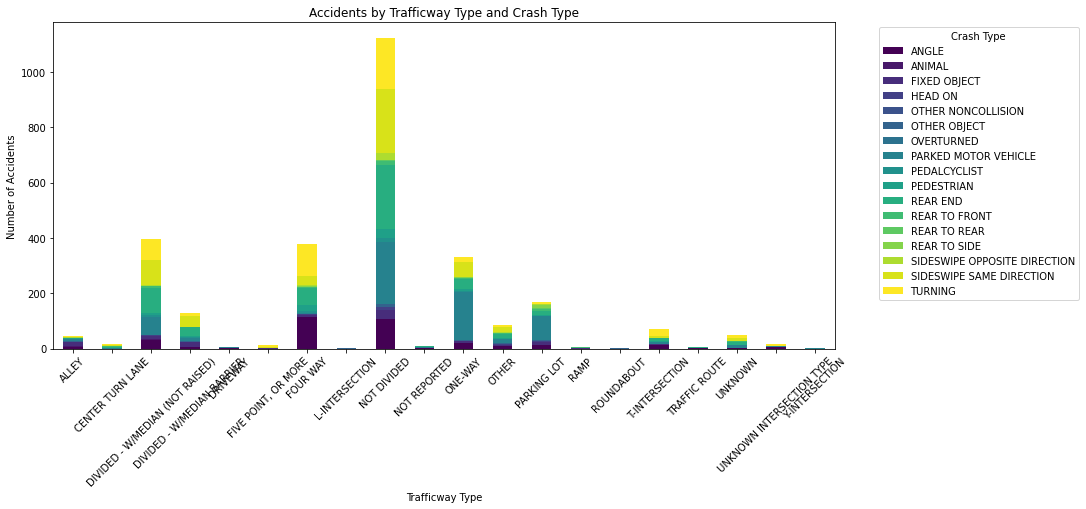

In [4]:
# ==========  Count accident types under different trafficway types ==========
trafficway_crash_counts = df_cleaned.groupby(["trafficway_type", "first_crash_type"]).size().unstack()

# ========== Generate a stacked bar chart ==========
plt.figure(figsize=(14, 6))
trafficway_crash_counts.plot(kind="bar", stacked=True, colormap="viridis", figsize=(14, 6))
plt.xlabel("Trafficway Type")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Trafficway Type and Crash Type")
plt.xticks(rotation=45)
plt.legend(title="Crash Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

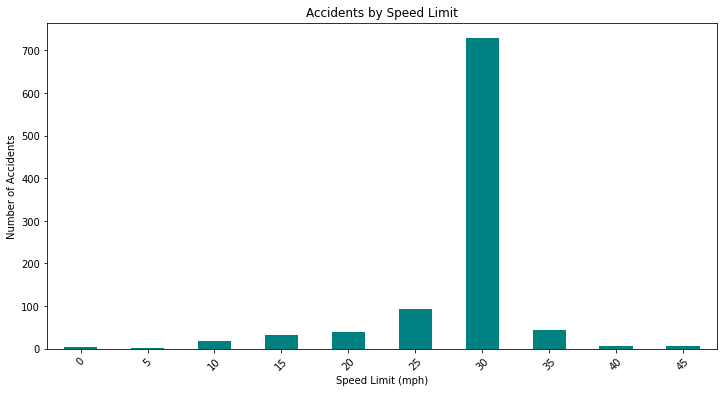

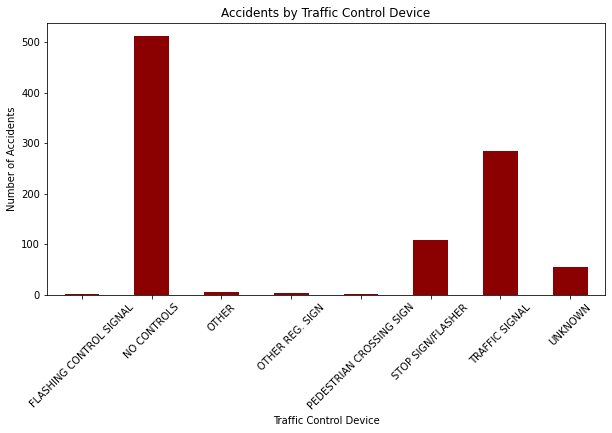

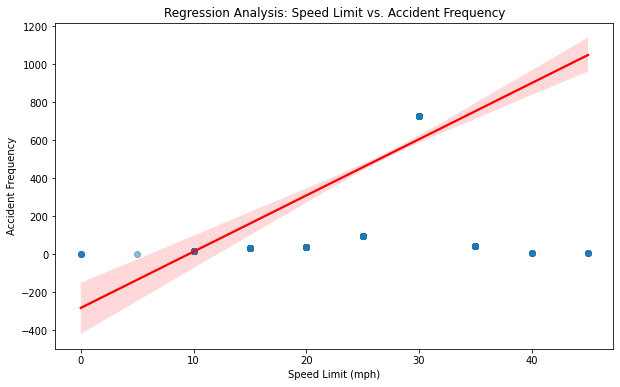

In [6]:
# ========== 1. Count the number of accidents under different speed limits ==========
speed_counts = df_cleaned.groupby("speed_limit").size()

plt.figure(figsize=(12, 6))
speed_counts.plot(kind="bar", color="teal")
plt.xlabel("Speed Limit (mph)")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Speed Limit")
plt.xticks(rotation=45)
plt.show()

# ========== 2. Analyze accident frequency with and without traffic signals ==========
traffic_signal_counts = df_cleaned.groupby("traffic_control_device").size()

plt.figure(figsize=(10, 5))
traffic_signal_counts.plot(kind="bar", color="darkred")
plt.xlabel("Traffic Control Device")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Traffic Control Device")
plt.xticks(rotation=45)
plt.show()

# ========== 3. Regression analysis: Speed limit vs. accident frequency ==========
plt.figure(figsize=(10, 6))
sns.regplot(x=df_cleaned["speed_limit"], y=df_cleaned.groupby("speed_limit")["crash_record_id"].transform("count"), 
            scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
plt.xlabel("Speed Limit (mph)")
plt.ylabel("Accident Frequency")
plt.title("Regression Analysis: Speed Limit vs. Accident Frequency")
plt.show()

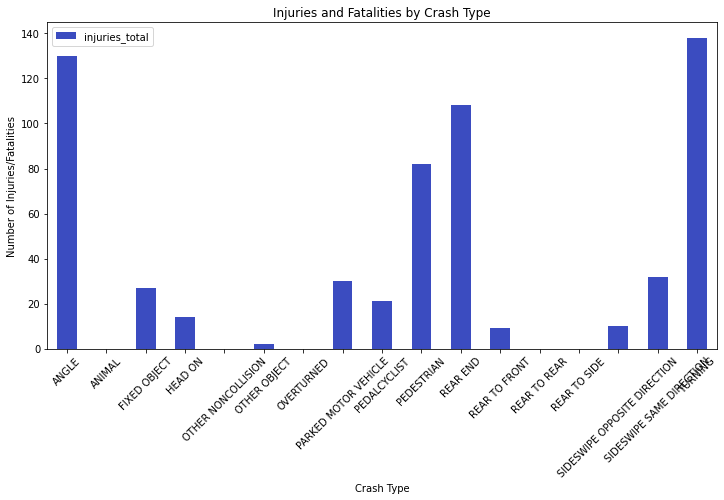

In [5]:
# Count the number of injury/fatality accidents for each crash type
injury_counts = df_cleaned.groupby("first_crash_type")[["injuries_total"]].sum()

# Plot a stacked bar chart
injury_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Crash Type")
plt.ylabel("Number of Injuries/Fatalities")
plt.title("Injuries and Fatalities by Crash Type")
plt.xticks(rotation=45)
plt.show()


In [5]:
import folium
from folium.plugins import HeatMap


m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)  
# add map
heat_data = df_cleaned[["latitude", "longitude"]].dropna().values.tolist()
HeatMap(heat_data).add_to(m)

# show map
m


In [9]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


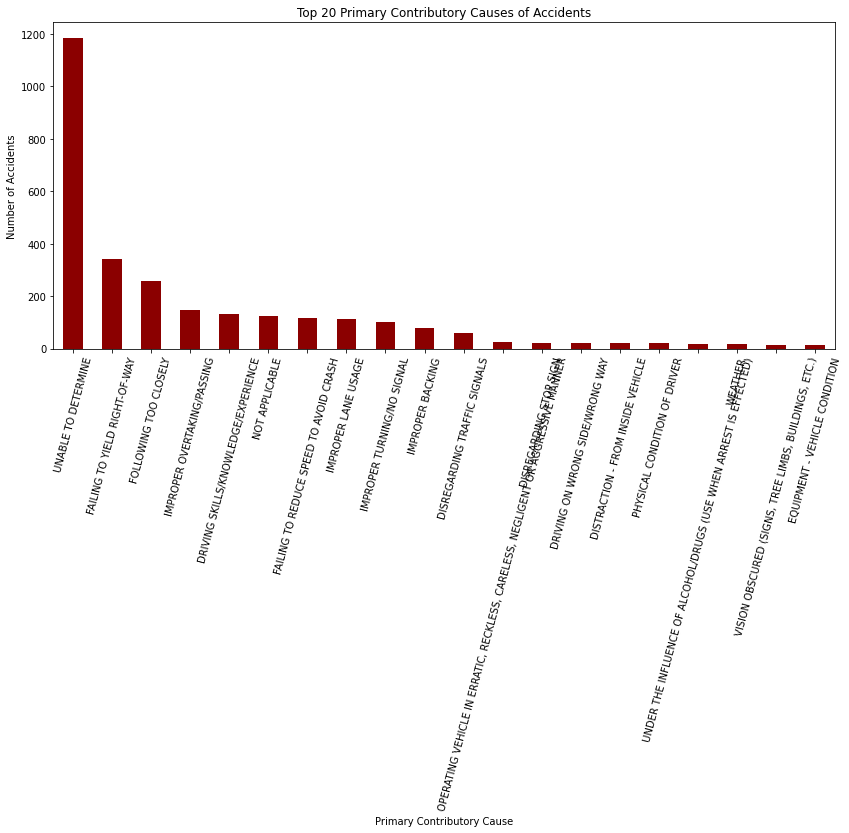

In [7]:
# Count the frequency of prim_contributory_cause.
cause_counts = df_cleaned["prim_contributory_cause"].value_counts()

plt.figure(figsize=(14, 6))
cause_counts.head(20).plot(kind="bar", color="darkred")  
plt.xlabel("Primary Contributory Cause")
plt.ylabel("Number of Accidents")
plt.title("Top 20 Primary Contributory Causes of Accidents")
plt.xticks(rotation=75)
plt.show()


In [10]:
from mlxtend.frequent_patterns import apriori, association_rules

# Select columns of interest (excluding the numerical speed_limit)
columns_of_interest = ["lighting_condition", "weather_condition", "first_crash_type"]
df_apriori = df_cleaned[columns_of_interest].dropna()

# One-Hot encoding (convert to 0/1 data suitable for Apriori rule mining)
df_apriori = pd.get_dummies(df_apriori)

df_cleaned["speed_limit_category"] = pd.cut(df_cleaned["speed_limit"], bins=[0, 30, 50, 70, 100], labels=["low", "medium", "high", "very_high"])
df_apriori = pd.concat([df_apriori, pd.get_dummies(df_cleaned["speed_limit_category"])], axis=1)

# Run Apriori rule mining
frequent_itemsets = apriori(df_apriori, min_support=0.1, use_colnames=True)

# Compute association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display strongly associated rules
print(rules.sort_values(by="lift", ascending=False).head(10))


                                         antecedents  \
48                     (lighting_condition_DAYLIGHT)   
47                   (low, first_crash_type_TURNING)   
43                     (lighting_condition_DAYLIGHT)   
42  (low, first_crash_type_SIDESWIPE SAME DIRECTION)   
8                      (lighting_condition_DAYLIGHT)   
9                         (first_crash_type_TURNING)   
49                        (first_crash_type_TURNING)   
46                (lighting_condition_DAYLIGHT, low)   
6                      (lighting_condition_DAYLIGHT)   
7        (first_crash_type_SIDESWIPE SAME DIRECTION)   

                                         consequents  antecedent support  \
48                   (low, first_crash_type_TURNING)            0.620196   
47                     (lighting_condition_DAYLIGHT)            0.155835   
43  (low, first_crash_type_SIDESWIPE SAME DIRECTION)            0.620196   
42                     (lighting_condition_DAYLIGHT)            0.156883   
8  

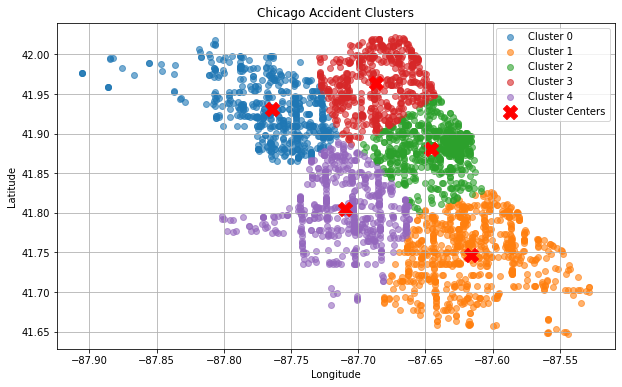

In [4]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from folium.plugins import MarkerCluster


# Load data
df = pd.read_csv("chicago_accidents_cleaned.csv")
df["crash_date"] = pd.to_datetime(df["crash_date"], errors="coerce")

# Filter out rows with missing latitude/longitude
geo_df = df.dropna(subset=["latitude", "longitude"])

# Select number of clusters
k = 5  # You can adjust this number

# Standardizing the latitude and longitude for clustering
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_df[["latitude", "longitude"]])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(geo_scaled)
geo_df["cluster"] = kmeans.labels_

# Get cluster centers in original coordinate space
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Plot clusters using matplotlib
plt.figure(figsize=(10, 6))
for i in range(k):
    cluster_data = geo_df[geo_df["cluster"] == i]
    plt.scatter(cluster_data["longitude"], cluster_data["latitude"], label=f"Cluster {i}", alpha=0.6)

plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], color="red", marker="X", s=200, label="Cluster Centers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Chicago Accident Clusters")
plt.legend()
plt.grid()
plt.show()

# Create a map centered on Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add accident locations with clustering
marker_cluster = MarkerCluster().add_to(m)
for _, row in geo_df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
    ).add_to(marker_cluster)

# Add cluster centers
for center in cluster_centers:
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(m)

# Show map 
m



In [13]:
!pip uninstall pandas scikit-learn numpy -y
!pip install pandas scikit-learn numpy


Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Successfully uninstalled pandas-1.3.5
Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Successfully uninstalled numpy-1.21.6
  Using cached pandas-1.3.5-cp37-cp37m-win_amd64.whl.metadata (12 kB)
  Using cached scikit_learn-1.0.2-cp37-cp37m-win_amd64.whl.metadata (10 kB)
  Using cached numpy-1.21.6-cp37-cp37m-win_amd64.whl.metadata (2.2 kB)
Using cached pandas-1.3.5-cp37-cp37m-win_amd64.whl (10.0 MB)
Using cached scikit_learn-1.0.2-cp37-cp37m-win_amd64.whl (7.1 MB)
Using cached numpy-1.21.6-cp37-cp37m-win_amd64.whl (14.0 MB)
